In [20]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

# Useful Functions

In [21]:
np.random.seed(99)

In [22]:
def draw_graph(G, colour_map):
    fig, ax = plt.subplots(figsize=(7, 7))
    nx.draw(G, node_color=colour_map, ax=ax, node_size=200)

In [23]:
# Method for initializing the weights of neural networks. It generates it with the bounds (-std, std) on a matrix of size (n_in, n_out). Stops gradient exploding/vanishing issues. Not random on a sigmoid function because the meaning of the values that are too big/small lose meaning

def xavier(n_in, n_out):
    std = np.sqrt(6.0 / (n_in + n_out))
    return np.random.uniform(-std, std, size=(n_in, n_out))


# Cross Entropy Loss for Classification Problem
"""Might need to change"""
def loss_calc(pred, labels):
    loss = 0
    for idx in range(len(pred)):
        loss += labels[idx] * np.log(pred)[idx]
    return -loss

# DataSet - Zachary's Karate Club

In [24]:
G = nx.karate_club_graph()

In [25]:
nx.is_weighted(G)

True

In [26]:
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
n_nodes, n_edges

(34, 78)

In [27]:
# nx.get_node_attributes(G,'club')

In [28]:
communities = greedy_modularity_communities(G)

In [29]:
colouring = np.zeros(n_nodes)
for idx, community in enumerate(communities):
    colouring[list(community)] = idx

n_labels = idx + 1
labels = np.eye(n_labels)[colouring.astype(int)]

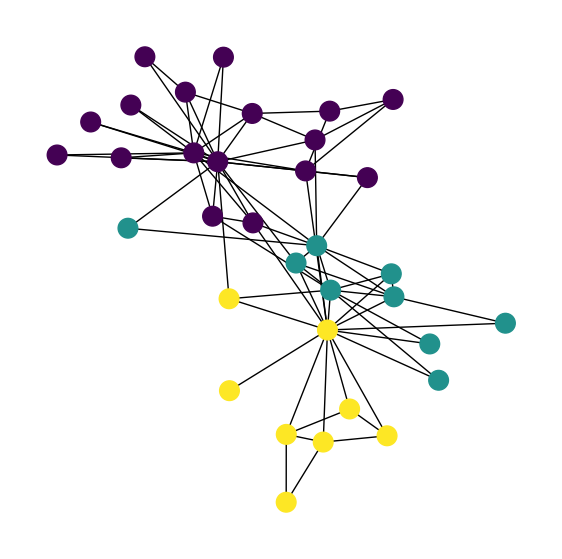

In [30]:
draw_graph(G, colouring)

# Adjacency Matrix

In [31]:
A = nx.to_numpy_array(G)

In [32]:
# Following https://arxiv.org/pdf/1609.02907.pdf
# Adding self connections
A_mod = A + np.eye(n_nodes)

D_mod = np.zeros_like(A_mod)
np.fill_diagonal(D_mod, np.asarray(A_mod.sum(axis=1)).flatten())

D_mod_invroot = np.linalg.inv(np.sqrt(D_mod))
A_hat = D_mod_invroot @ A_mod @ D_mod_invroot

In [33]:
#Input features, Since we dont have any node features, just start with an identity matrix
X = np.eye(n_nodes)

# Optimiser

In [34]:
class Optimiser:
    def __init__(self, learning_rate, weight_decay):
        self.lr = learning_rate
        self.wd = weight_decay
        self.out = None
        self.y_pred = None
        self.y_true = None
        self.out = None
        self.train_nodes=None
        self.n_inputs = None


# Graph Convolution Network Layer

In [35]:
class GCNLayer:
    def __init__(self, n_inputs, n_outputs, activation, name):
        #Number of input/output features
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        # Initialising weights 
        self.weights = xavier(self.n_outputs, self.n_inputs)
        # Activation function if needed, probably not gonna use it but ok
        self.act_func = activation
        # Convenient display
        self.name = name
        #Used Later
        # Normalised Adjacency Matrix A
        self.adjacency_m = None
        # Matrix to represent th message passing stage A @ X
        self.message_passing_m = None
        # H 
        self.layer_output_m = None

    #Forward propagation and message sharing among nodes
    def forward(self, A, previous_layer_output, W=None):
        self.adjacency_m = A
        self.message_passing_m = (self.adjacency_m @ previous_layer_output).T
        
        if W is None:
            W = self.weights
        
        self.layer_output_m = W @ self.message_passing_m
        self.layer_output_m = self.act_func(self.layer_output_m)
        return self.layer_output_m.T
    
    # Backwards propagation, correcting for loss.
    def backward(self, optimiser:Optimiser):
        d_tanh = 1 - np.asarray(self.layer_output_m.T) ** 2
        d2 = d_tanh * optimiser.out
        
        gradient = self.adjacency_m @ d2 @ self.W
        optimiser.out = gradient

        #Same as SoftMax Layer without bias
        dW = (d2.T @ self.message_passing_m.T) / optimiser.n_inputs
        dW_wd = self.W * optimiser.wd / optimiser.n_inputs
        
        #Updating W
        self.W -= (dW + dW_wd) * optimiser.lr
        
        return dW + dW_wd



# SoftMax Layer

In [36]:
class SoftmaxLayer:
    def __init__(self, n_inputs, n_outputs, name):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = xavier(self.n_outputs, self.n_inputs)
        self.bias = np.zeros(shape=(self.n_outputs, 1))
        self.name = name
        self._X = None  # Used to calculate gradients

    def softmax(self, input):
        s = np.max(input, axis=1)
        s = s[:, np.newaxis] # necessary step to do broadcasting
        e_x = np.exp(input - s)
        div = np.sum(e_x, axis=1)
        div = div[:, np.newaxis] 
        return e_x / div
    
    def forward(self, input_feature_m, W=None, bias=None):
        self.input_feature_m = X.T
        if W is None:
            W = self.W
        if bias is None:
            bias = self.bias
        
        final_layer_out = np.asarray(W @ self._X) + bias
        return self.softmax(final_layer_out.T)
    
    def backward(self, optimiser: Optimiser):
        # Build mask on loss, only use the nodes in training
        train_mask = np.zeros(optimiser.y_pred.shape[0])
        train_mask[optimiser.train_nodes] = 1
        train_mask = train_mask.reshape((-1, 1))

        # derivative of loss w.r.t. activation (pre-softmax)
        d1 = np.asarray((optimiser.y_pred - optimiser.y_true)) 
        d1 = np.multiply(d1, train_mask)
        
        #Create gradient by multiplying difference with weights
        gradient = d1 @ self.W 
        optimiser.out = gradient
        
        #Calculate change in W matrix and b for the softmax layer
        #Change in learnable weights
        dW = (d1.T @ self.input_feature_m.T) / optimiser.n_inputs
        #Change in bias
        db = d1.T.sum(axis=1, keepdims=True) / optimiser.n_inputs 
        #Change due to weight decay, L2 Regularization
        dW_wd = self.W * optimiser.wd / optimiser.n_inputs
        
        # Updating Weights and biases * learning rate
        self.W -= (dW + dW_wd) * optimiser.lr
        self.bias -= db.reshape(self.bias.shape) * optimiser.lr
        
        return dW + dW_wd, db.reshape(self.bias.shape) #Do we use this?
        

In [37]:
gcn1 = GCNLayer(n_nodes, 2, activation=np.tanh, name='1')
sm1 = SoftmaxLayer(2, 3, "SM")
opt = Optimiser(0.03, 0.04)